In [1]:
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras import layers
import sklearn.metrics as skm
import os
import matplotlib.pyplot as plt
import itertools

2023-06-15 12:02:26.387287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
#Generate configurations

hidden_layers = [2, 3, 4]
hidden_nodes = [26, 5, 11, 20, 32, 40]
activation = ['sigmoid', 'relu']

configurations = []

for index, combination in enumerate(itertools.product(hidden_layers, hidden_nodes, activation), 1):
    config = {
        'config_name': f'config{index}',
        'hidden_layers' : combination[0],
        'hidden_nodes': combination[1],
        'activation': combination[2]
    }
    configurations.append(config)


Start of the training of config8
Start of the training of config9
Start of the training of config10
Start of the training of config11
Start of the training of config12
Start of the training of config13
Start of the training of config14
Start of the training of config15
Start of the training of config16
Start of the training of config17
Start of the training of config18
Start of the training of config19
Start of the training of config20
Start of the training of config21
a
Start of the training of config22
Start of the training of config23
Start of the training of config24
Start of the training of config25
Start of the training of config26
Start of the training of config27
Start of the training of config28
Start of the training of config29
Start of the training of config30
Start of the training of config31
Start of the training of config32
Start of the training of config33
Start of the training of config34
Start of the training of config35
Start of the training of config36
{'config_name'

In [3]:
# Load the dataset
data_path = '/Users/as274094/Documents/psf_dataset2/'
# data_path = '/gpfswork/rech/prk/uzk69cg/psf_dataset2/'

In [4]:
def SEDlisttoC(SED_list):
    sed_array = np.array(SED_list)
    return sed_array*0.5 + 1.5

def CtoSEDarray(c_values, variance):
    sed_classes = ((c_values - 1.25) // 0.5).astype(int)
    sed_classes = np.where((c_values < 1.25) | (c_values > 7.75), 20, sed_classes)
    sed_classes = np.where((variance > 1.00), 20, sed_classes)
    return sed_classes

def calculate_success_rate(confusion_matrix):
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

In [5]:
class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)

completion_callback = TrainingCompletionCallback()

initializer = tf.keras.initializers.GlorotNormal(seed = 25)

In [6]:
class full_model:
    def __init__(self, dataset_name, configuration):
        self.dataset_name = dataset_name
        dataset = np.load(data_path + dataset_name + ".npy", allow_pickle=True)[()]
        self.PCA_components = dataset['N_components']
        self.x_train = dataset['train_stars_pca']
        self.x_val = dataset['validation_stars_pca']
        self.x_test = dataset['test_stars_pca']
        self.y_train = dataset['train_C']
        self.y_val = dataset['validation_C']
        self.y_test = dataset['test_C']
        self.SED_val = dataset['validation_SEDs']
        self.SED_test = dataset['test_SEDs']
        self.learning = []
        self.configuration = configuration

    def create_model(self):
        
        self.model = tf.keras.Sequential()
        self.model.add(layers.Input(shape=[self.PCA_components]))
        for n_layers in range(self.configuration['hidden_layers']):
            self.model.add(layers.Dense(self.configuration['hidden_nodes'], activation= self.configuration['activation'], kernel_initializer= initializer))
        self.model.add(layers.Dense(1, activation = 'linear', kernel_initializer= initializer))
        
    
    def train_model(self, learning_rate, training_epochs, patience_epochs):

        self.model.compile(
            loss = tf.keras.losses.MeanSquaredError(),
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        )
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)

        learn = self.model.fit(self.x_train, self.y_train, epochs= training_epochs, verbose = 0,
                                        callbacks = [completion_callback,early_stopping], validation_data=(self.x_val,self.y_val), shuffle=True) 

        self.learning.append(learn)

    def predict_test(self, verbose = True):
        C_pred = self.model.predict(self.x_test, verbose = 0).reshape(-1)
        SED_pred_test = CtoSEDarray(C_pred,np.zeros_like(C_pred))

        self.mse_test = np.mean((self.y_test - C_pred)**2)
        self.f1_test = skm.f1_score(self.SED_test, SED_pred_test, average = None)
        self.f1_mean_test = np.mean(self.f1_test[:13])
        self.confusion_matrix_test = skm.confusion_matrix(self.SED_test, SED_pred_test)
        self.success_rate_test = calculate_success_rate(self.confusion_matrix_test)

        if(verbose):
            print("Prediction results for the test set")
            print('MSE:', self.mse_test)
            print('\nF1 score for each class:', self.f1_test)
            print('Average F1 score:', self.f1_mean_test)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_test)
            print('\nSuccess rate:', self.success_rate_test)


    def predict_val(self, verbose = True):
        C_pred = self.model.predict(self.x_val, verbose = 0).reshape(-1)
        SED_pred_val = CtoSEDarray(C_pred,np.zeros_like(C_pred))

        self.mse_val = np.mean((self.y_val - C_pred)**2) 
        self.f1_val = skm.f1_score(self.SED_val, SED_pred_val, average = None)
        self.f1_mean_val = np.mean(self.f1_val[:13])
        self.confusion_matrix_val = skm.confusion_matrix(self.SED_val, SED_pred_val)
        self.success_rate_val = calculate_success_rate(self.confusion_matrix_val)

        if(verbose):
            print("Prediction results for the validation set")
            print('MSE:', self.mse_val)
            print('\nF1 score for each class:', self.f1_val)
            print('Average F1 score:', self.f1_mean_val)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_val)
            print('\nSuccess rate:', self.success_rate_val)

    def save_model(self, N_model):

        self.model.save(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")

    def load_model(self, N_model):
        self.model = tf.keras.models.load_model(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")
        

    def plot_loss(self):
    # Plot the loss function evolution

        loss_evolution = self.learning[-1].history["loss"]
        val_loss_evolution = self.learning[-1].history["val_loss"]

        plt.figure(figsize = (9,5))
        plt.plot(loss_evolution,label = "Train set")
        plt.plot(val_loss_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Loss function value")
        plt.legend()
        plt.title("Loss function evolution")
        print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])

    def plot_cf_matrix(self):
        # Plot the confusion matrix

        star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

        plt.figure(figsize= (12,10))
        heatmap = plt.imshow(self.confusion_matrix_test[:13,:], cmap='Blues')
        plt.xticks(np.arange(14), star_class_labels + ['???'])
        plt.yticks(np.arange(13), star_class_labels)
        plt.colorbar(heatmap)
        plt.xlabel("Estimated spectral type")
        plt.ylabel("True spectral type")
        plt.show()

In [8]:
def start_array(N_components, N_model_dataset, configuration):
    model_array = np.empty((len(N_components),N_model_dataset), dtype=object)

    total_start_time = time.time() # Measure training time
    for i in range(model_array.shape[0]):
        print('Start of the training of PCA_dataset2B' + str(N_components[i]))
        for j in range(model_array.shape[1]):
            model = full_model('PCA_dataset2B' + str(N_components[i]), configuration)
            model.create_model()

            single_start_time = time.time()
            model.train_model(training_epochs= 70, learning_rate= 0.1, patience_epochs= 10)
            model.train_model(training_epochs= 100, learning_rate= 0.01, patience_epochs= 12)
            single_end_time = time.time()
            single_training_time = single_end_time - single_start_time
            print("Model training time:", single_training_time, "seconds")

            model.predict_val(verbose=0)
            model.predict_test(verbose=0)
            model_array[i][j]= model
        print('End of the training of PCA_dataset2B' + str(N_components[i]))

    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print("Total training time:", total_training_time, "seconds")

    return model_array

def predict_array(model_array):
    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model_array[i][j].predict_val(verbose=False)
            model_array[i][j].predict_test(verbose=False)

def save_model_array(model_array):
    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model = model_array[i][j]
            model.save_model(j)

def load_model_array(N_components, N_model_dataset, configuration):
    model_array = np.empty((len(N_components), N_model_dataset), dtype=object)

    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model = full_model('PCA_dataset2B' + str(N_components[i]), configuration)
            model.load_model(j)
            model_array[i][j] = model

    return model_array
    

In [ ]:
# Create model array

N_components = [12, 15, 18, 21, 24, 27, 30, 33]

model_array = start_array(N_components, 10, configurations[0])

In [42]:
array_list= [model_array]


0


In [64]:
def obtain_metric(model_array, metric):
    metric_array = np.zeros_like(model_array) 

    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model = model_array[i][j]
            metric_array[i][j] = getattr(model, metric)
    return metric_array

def obtain_graph_values(model_array, metric):
    metric_array = obtain_metric(model_array, metric)

    mean_values = np.mean(metric_array, axis=1).astype(float)
    min_values = np.min(metric_array, axis=1).astype(float)
    max_values = np.max(metric_array, axis=1).astype(float)
    return mean_values, min_values, max_values

def obtain_best_models(model_array):
    best_models = np.empty((model_array.shape[0],1), dtype = object)

    F1_array = obtain_metric(model_array, 'f1_mean_test')
    indexes = np.argmax(F1_array, axis=1)
    print(indexes)
    for N in range(model_array.shape[0]):
        model = model_array[N][indexes[N]]
        best_models[N] = model

    return best_models

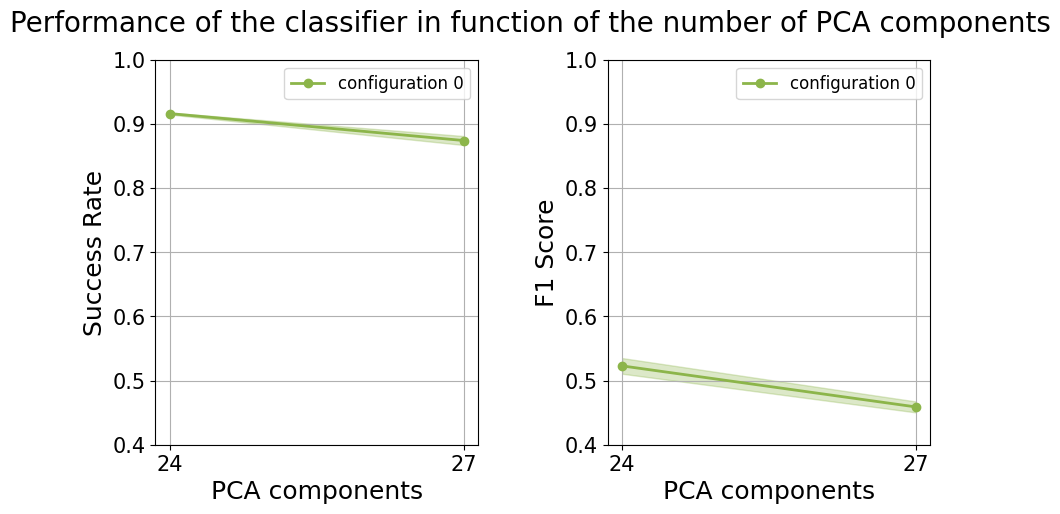

In [65]:
#Plot the metrics of different configuration arrays with their error shape

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

np.random.seed(3)
# Plotting the success rate
for i, model_array in enumerate(array_list):
    col = np.random.random(3,)
    mean_valuesSt, minSt, maxSt = obtain_graph_values(model_array, 'success_rate_test')
    mean_valuesF1t, minF1t, maxF1t = obtain_graph_values(model_array, 'f1_mean_test')

    ax1.plot(N_components, mean_valuesSt, '-o', label='configuration '+str(i), color= col, linewidth=2)
    ax1.fill_between(N_components, minSt, maxSt, alpha=0.3, color=col)

    ax2.plot(N_components, mean_valuesF1t, '-o', label='configuration '+str(i), color=col, linewidth=2)
    ax2.fill_between(N_components, minF1t, maxF1t, alpha=0.3, color=col)


ax1.set_xlabel("PCA components", fontsize=18)
ax1.set_ylabel("Success Rate", fontsize=18)
ax1.set_xticks(N_components)
ax1.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.grid(True)
ax1.legend(fontsize=12)

# Plotting the F1 score

ax2.set_xlabel("PCA components", fontsize=18)
ax2.set_ylabel("F1 Score", fontsize=18)
ax2.set_xticks(N_components)
ax2.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.grid(True)
ax2.legend(fontsize=12)

# Set the title for the entire figure
fig.suptitle('Performance of the classifier in function of the number of PCA components', fontsize=20)

# Adjust the spacing between subplots
#plt.subplots_adjust(hspace=1.3)
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()